In [16]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import pydeck as pdk

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [17]:
df_rental = pd.read_csv('../data/bike_rental_history/processed/2023_weekday_sample.csv')
df_rental = df_rental.drop(['대여 대여소명', '반납대여소명', 'date'], axis=1)

In [18]:
df_rental = df_rental.rename(columns={'자전거번호':'bike_id',
                                      '대여일시':'rent_datetime',
                                      '반납일시':'return_datetime',
                                      '대여대여소ID':'origin_station_id',
                                      '반납대여소ID':'desti_station_id',
                                      '생년':'birth_year',
                                      '이용자종류':'user_type',
                                      '성별':'gender',
                                      '자전거구분':'bike_type'
                                      })

df_rental.loc[:,'rent_datetime'] = pd.to_datetime(df_rental['rent_datetime'])
df_rental.loc[:,'return_datetime'] = pd.to_datetime(df_rental['return_datetime'])

df_rental.loc[:,'rent_hour'] = df_rental['rent_datetime'].dt.hour

df_rental = df_rental.loc[df_rental.loc[:,'origin_station_id'] != df_rental.loc[:,'desti_station_id'], :]

C:\Users\seung\AppData\Local\Temp\ipykernel_10680\3445242675.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_rental.loc[:,'rent_datetime'] = pd.to_datetime(df_rental['rent_datetime'])
C:\Users\seung\AppData\Local\Temp\ipykernel_10680\3445242675.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_rental.loc[:,'return_datetime'] = pd.to_datetime(df_rental['return_datetime'])


In [19]:
df_rental.shape

(124275, 10)

In [20]:
unique_origin_stations = df_rental['origin_station_id'].nunique()
print(f'the number of unique origin stations: {unique_origin_stations}')

unique_desti_stations = df_rental['desti_station_id'].nunique()
print(f'the number of unique origin stations: {unique_desti_stations}')

the number of unique origin stations: 2775
the number of unique origin stations: 2756


C:\Users\seung\AppData\Local\Temp\ipykernel_10680\1319203978.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  barplot.set_yticklabels(barplot.get_yticks(), size=12)


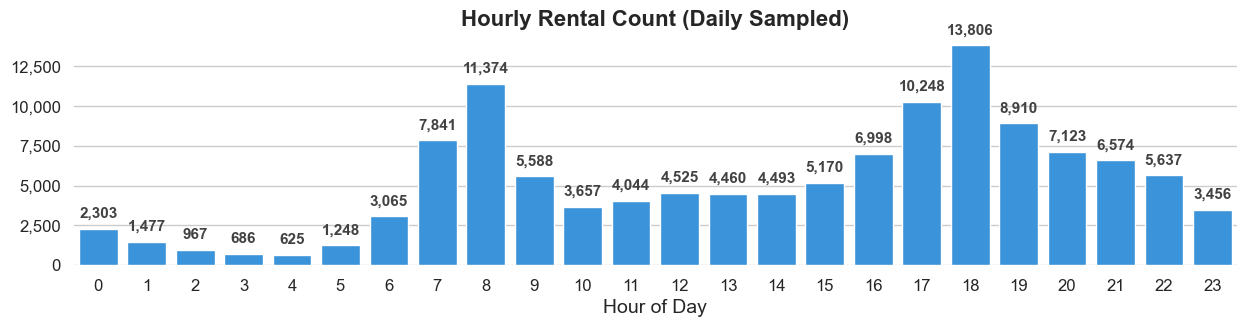

In [21]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 3))

df_hourly_count = df_rental.groupby('rent_hour').size().reset_index(name='rental_count')

barplot = sns.barplot(x='rent_hour', y='rental_count', data=df_hourly_count, color='#2196f3')

# styling
barplot.set_title('Hourly Rental Count (Daily Sampled)', fontsize=16, fontweight='bold')
barplot.set_xlabel('Hour of Day', fontsize=14)
barplot.set_ylabel('')
barplot.set_xticklabels(barplot.get_xticks(), size=12)
barplot.set_yticklabels(barplot.get_yticks(), size=12)

# seperate comma in y-axis
def format_func(value, tick_number):
    return f'{int(value):,}'

formatter = FuncFormatter(format_func)
barplot.yaxis.set_major_formatter(formatter)

for container in barplot.containers:
    barplot.bar_label(container, labels=[f'{int(label):,}' for label in container.datavalues], fontsize=11, weight='bold', padding=6, color='#424242')

sns.despine(left=True, bottom=True)
plt.show()

In [22]:
gdf_station = gpd.read_file('../data/station/bike_station.geojson')

In [23]:
gdf_station.loc[:,'nearby_subway'] = gdf_station.loc[:,'dist_to_subway'] < 100

In [24]:
gdf_station

,station_id,address,address_detail,latitude,longitude,dist_to_subway,geometry,nearby_subway
0,ST-997,서울특별시 양천구 목동중앙로 49,목동3단지 시내버스정류장,37.534390,126.869598,1011.885895,POINT (188404.676 448023.915),False
1,ST-996,서울특별시 양천구 남부순환로88길5-16,양강중학교앞 교차로,37.524334,126.850548,504.224092,POINT (186719.138 446910.345),False
2,ST-995,서울특별시 양천구 중앙로 153 공중화장실,NaN,37.510597,126.857323,777.296433,POINT (187315.694 445384.759),False
3,ST-994,서울특별시 양천구 목동서로161,SBS방송국,37.529163,126.872749,560.822569,POINT (188682.385 447443.391),False
4,ST-993,서울특별시 양천구 신월로 342-1 구두수선대19,NaN,37.521511,126.857384,401.021544,POINT (187322.943 446596.077),False
...,...,...,...,...,...,...,...,...
3279,ST-1003,서울특별시 양천구 화곡로 59,신월동 이마트,37.539551,126.828300,1096.610445,POINT (184755.579 448602.649),False
3280,ST-1002,서울특별시 양천구 목동동로 316-6,서울시 도로환경관리센터,37.529900,126.876541,611.711570,POINT (189017.675 447524.738),False
3281,ST-1000,서울특별시 양천구 신정동 236,서부식자재마트 건너편,37.510380,126.866798,240.117803,POINT (188153.380 445359.433),False
3282,ST-100,서울특별시 광진구 아차산로 262,더샵스타시티 C동 앞,37.536667,127.073593,510.952220,POINT (206434.705 448270.900),False


In [25]:
df_rental = df_rental.merge(gdf_station[['station_id', 'nearby_subway']], left_on='desti_station_id', right_on='station_id', how='left')
df_rental = df_rental.drop('station_id', axis=1)
df_rental = df_rental.rename(columns={'nearby_subway':'desti_nearby_subway'})

df_rental = df_rental.merge(gdf_station[['station_id', 'nearby_subway']], left_on='origin_station_id', right_on='station_id', how='left')
df_rental = df_rental.drop('station_id', axis=1)
df_rental = df_rental.rename(columns={'nearby_subway':'origin_nearby_subway'})

In [26]:
df_rental.loc[:,'nearby_subway'] = df_rental['origin_nearby_subway'] | df_rental['desti_nearby_subway']

In [27]:
df_rental.loc[:,'nearby_subway'].sum() / len(df_rental)

0.37048494721343317

C:\Users\seung\AppData\Local\Temp\ipykernel_10680\3327237955.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  barplot_true.set_yticklabels(barplot_true.get_yticks(), size=12)


<Axes.ArtistList of 48 patches>


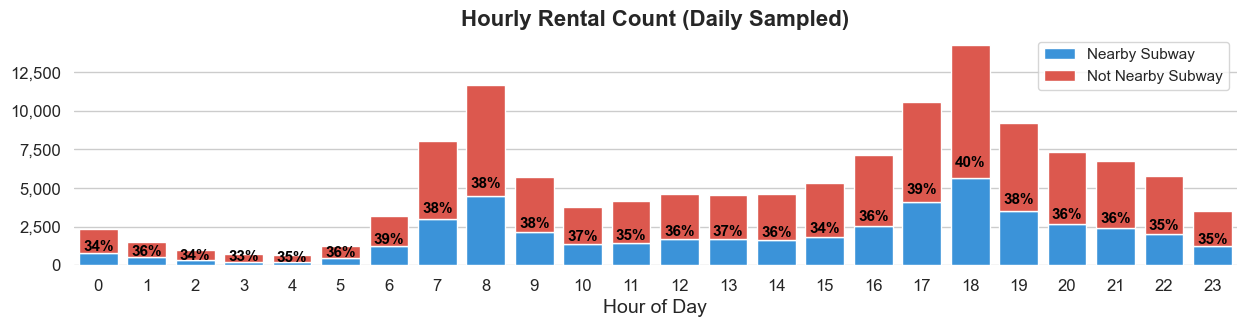

In [28]:
df_hourly_count = df_rental.groupby(['rent_hour', 'nearby_subway']).size().reset_index(name='rental_count')
df_hourly_pivot = df_hourly_count.pivot(index='rent_hour', columns='nearby_subway', values='rental_count').fillna(0)

df_hourly_pivot['total'] = df_hourly_pivot[True] + df_hourly_pivot[False]
df_hourly_pivot['nearby_ratio'] = df_hourly_pivot[True] / df_hourly_pivot['total']
df_hourly_pivot['not_nearby_ratio'] = df_hourly_pivot[False] / df_hourly_pivot['total']

sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 3))

# 막대 차트 생성
barplot_true = sns.barplot(x=df_hourly_pivot.index, y=df_hourly_pivot[True], color='#2196f3', label='Nearby Subway')
barplot_false = sns.barplot(x=df_hourly_pivot.index, y=df_hourly_pivot[False], bottom=df_hourly_pivot[True], color='#f44336', label='Not Nearby Subway')

# 스타일링
barplot_true.set_title('Hourly Rental Count (Daily Sampled)', fontsize=16, fontweight='bold')
barplot_true.set_xlabel('Hour of Day', fontsize=14)
barplot_true.set_ylabel('')
barplot_true.set_xticklabels(barplot_true.get_xticks(), size=12)
barplot_true.set_yticklabels(barplot_true.get_yticks(), size=12)

# y축 레이블을 콤마로 구분
def format_func(value, tick_number):
    return f'{int(value):,}'

formatter = FuncFormatter(format_func)
barplot_true.yaxis.set_major_formatter(formatter)

print(barplot_false.patches)

# 막대에 비율 레이블 추가
for i in range(len(df_hourly_pivot)):
    true_height = df_hourly_pivot[True][i]
    
    barplot_true.text(i, true_height + 0.05 * df_hourly_pivot['total'][i],
                      f'{df_hourly_pivot["nearby_ratio"][i]:.0%}', 
                      ha='center', fontsize=11, weight='bold', color='black')


sns.despine(left=True, bottom=True)

# 범례 추가
plt.legend()

plt.show()

In [32]:
df_rental_by_route = df_rental.groupby(['origin_station_id', 'desti_station_id']).size().reset_index(name='count').sort_values('count', ascending=False)

In [45]:
df_rental_by_route.to_csv('../data/bike_rental_history/processed/2023_weekday_sample_by_route.csv', index=False)

<Axes: >

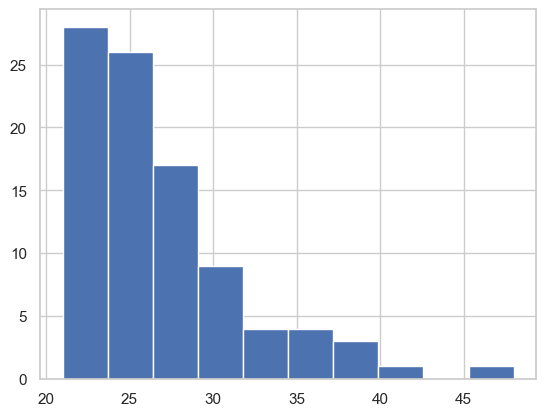

In [43]:
df_rental_by_route.loc[df_rental_by_route.loc[:,'count'] > 20, 'count' ].hist()